# Solution 

- Date: 13th August 2023
- Generator: OpenAI Code Interpreter ChatGPT 4 version [2023 August 3 Version](https://help.openai.com/en/articles/6825453-chatgpt-release-notes). 

In [143]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [237]:
def get_bearing(vector):
    x1, y1 = 0,0
    x2, y2 = vector

    # Calculate the angle from the positive x-axis to the line connecting the points
    angle_rad = np.arctan2(y2 - y1, x2 - x1)

    # Convert the angle from radians to degrees
    angle_deg = np.degrees(angle_rad)

    # Convert to bearing by measuring clockwise from North
    bearing = (90 - angle_deg + 360) % 360

    return bearing
get_bearing((1,1))

45.0

In [226]:
def get_vector(bearing, length):
    # Convert bearing to angle measured counterclockwise from the positive x-axis
    angle = (90 - bearing) % 360
    
    # Compute x and y components using cosine and sine
    x = length * np.cos(np.radians(angle))
    y = length * np.sin(np.radians(angle))
    
    return np.array([x, y])

get_vector(-45, 1).round(1)


array([-0.7,  0.7])

In [227]:
def get_distance(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    p1 = np.array([x1, y1])
    p2 = np.array([x2, y2])

    return np.linalg.norm(p2 - p1)
get_distance((0,0), (3,4))

5.0

In [267]:
class MotorboatEnv(gym.Env):
    def __init__(self):
        super().__init__()

        # Action space: throttle [-1, 1], steer [-30, 30]
        self.action_space = spaces.Box(low=np.array([-1, -30]), high=np.array([1, 30]), dtype=np.float32)
        
        # Observation space: boat x, y, target x, y, current vector x, y, boat heading
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(8,), dtype=np.float32)

        # Parameters
        self.max_timesteps = 1000
        self.current_strength = 0.1
        self.target_position = np.array([0.0, 0.0])

        self.reset()
    
    def _get_observation(self):
        current_vector = get_vector(self.current_heading, self.current_strength)
        observation = np.array([
            self.boat_position[0],  # boat x
            self.boat_position[1],  # boat y
            self.target_position[0],  # target x
            self.target_position[1],  # target y
            current_vector[0],  # current x
            current_vector[1],  # current y
            self.boat_heading  # boat heading
        ])
        return observation
    
    def step(self, action):
        # Extract and truncate actions
        throttle, steer = np.clip(action, [-1, -30], [1, 30])

        # Change heading of boat
        self.boat_heading = (self.boat_heading + steer) % 360

        # Compute velocity due to throttle
        boat_velocity = get_vector(self.boat_heading, throttle)
        
        # Compute velocity due to current
        current_velocity = get_vector(self.current_heading, self.current_strength)
        
        # Update boat position
        self.boat_position += boat_velocity + current_velocity

        # Compute distance to target
        distance_to_target = get_distance(self.boat_position, self.target_position)

        # Check if done
        time_out = self.timesteps >= self.max_timesteps
        target_reached = distance_to_target < 0.5
        done = time_out or target_reached

        # Compute reward
        reward = -distance_to_target + (100 if target_reached else 0)

        # Update timesteps
        self.timesteps += 1

        # Create observation
        observation = self._get_observation()

        return observation, reward, done, False, {}

    def reset(self):
        self.timesteps = 0

        # Randomly initialize the boat's position on a circle with radius 10
        angle = np.random.uniform(0, 2 * np.pi) # Random angle in radians
        self.boat_position = np.array([
            10 * np.cos(angle),
            10 * np.sin(angle)
        ])

        # Randomly initialize the boat's bearing
        self.boat_heading = np.random.uniform(0, 360) # Random angle in degrees

        # Randomly initialize the current's bearing
        self.current_heading = np.random.uniform(0, 360) # Random angle in degrees
        self.current_strength = 0.1

        observation = self._get_observation()
        return observation


    def render(self, mode='human'):
        # Optional: Implement a rendering method to visualize the environment
        output = [
            f"Boat: ({round(self.boat_position[0], 2)} {round(self.boat_position[1], 2)}) heading {round(self.boat_heading, 2)}",
            f"Target: ({self.target_position[0]} {self.target_position[1]}) bearing {get_bearing(self.target_position - self.boat_position)} dist {get_distance(self.boat_position, self.target_position)}",
            f"Current: {self.current_strength} heading {self.current_heading}"
        ]
        print('\n'.join(output), '\n')


In [273]:
env = MotorboatEnv()
env.reset()
env.boat_position = np.array([0.0,-10.0])
env.boat_heading = 0.0
env.current_heading = 90.0
env.render()
for i in range(20):
    throttle = 1.0 #float(input('throttle:'))
    steer = float(input('steer:'))
    observation, reward, done, truncated, info = env.step([throttle, steer])
    env.render()
    if done:
        print('Done!')
        break


Boat: (0.0 -10.0) heading 0.0
Target: (0.0 0.0) bearing 0.0 dist 10.0
Current: 0.1 heading 90.0 

Boat: (0.1 -9.0) heading 0.0
Target: (0.0 0.0) bearing 359.3634064240365 dist 9.000555538409838
Current: 0.1 heading 90.0 

Boat: (0.2 -8.0) heading 0.0
Target: (0.0 0.0) bearing 358.56790381583534 dist 8.002499609497024
Current: 0.1 heading 90.0 

Boat: (0.3 -7.0) heading 0.0
Target: (0.0 0.0) bearing 357.5459683254729 dist 7.006425622241344
Current: 0.1 heading 90.0 

Boat: (0.4 -6.0) heading 0.0
Target: (0.0 0.0) bearing 356.18592516570965 dist 6.013318551349164
Current: 0.1 heading 90.0 

Boat: (0.48 -5.0) heading 359.0
Target: (0.0 0.0) bearing 354.4876511536396 dist 5.023382849403977
Current: 0.1 heading 90.0 

Boat: (0.48 -4.01) heading 354.0
Target: (0.0 0.0) bearing 353.1946884553073 dist 4.034052214119395
Current: 0.1 heading 90.0 

Boat: (0.44 -3.02) heading 352.0
Target: (0.0 0.0) bearing 351.71949494592724 dist 3.047129121546789
Current: 0.1 heading 90.0 

Boat: (0.37 -2.03) h

In [278]:
class OptimalMotorboatAgent:
    def __init__(self, action_space = None):
        self.action_space = action_space

    def act(self, observation):
        boat_x, boat_y, target_x, target_y, current_x, current_y, boat_heading = observation
        
        throttle = 1
        steer = np.random.uniform(-30, 30)
        return [throttle, steer]


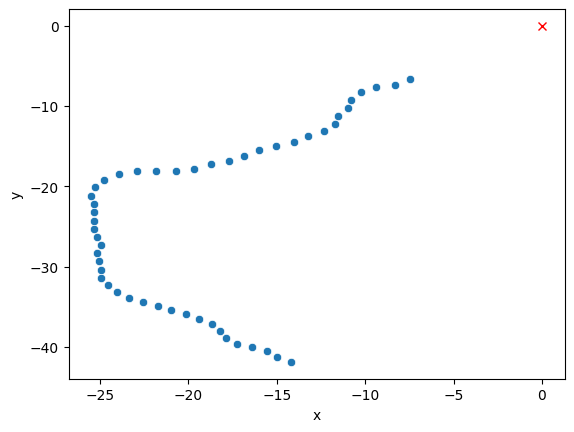

In [286]:
env = MotorboatEnv()
agent = OptimalMotorboatAgent()

observation = env.reset()
trace = []
for i in range(50):
    trace.append(env.boat_position.tolist() + [i])
    # action = env.action_space.sample()
    action = agent.act(observation)
    observation, reward, done, truncated, info = env.step(action)
    
    # draw
    clear_output(wait=True)
    df = pd.DataFrame(trace, columns=['x', 'y', 'i'])
    sns.scatterplot(data=df, x='x', y='y')
    target_x, target_y = observation[2], observation[3]
    plt.plot(target_x, target_y, marker='x', color='r')
    plt.show()

    if done:
        print('Done:', env.boat_position)
        break